<a href="https://colab.research.google.com/github/cgoeser1/MSDS422_course_assignments/blob/main/Group1_MNIST(2021OCT31).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Requirements

1. Fit a random forest classifier using the full set of explanatory variables and the model training set (csv).
2. Record the time it takes to fit the model and then evaluate the model on the csvdata by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.
3. Execute principal components analysis (PCA) on the combined training and test set data together, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the explanatory variables.
4. Record the time it takes to identify the principal components.
5. Using the identified principal components from step (2), use thecsvto build another random forest classifier.
6. Record the time it takes to fit the model and to evaluate the model on the csvdata by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.
7. Use k-means clustering to group MNIST observations into 1 of 10 categories and then assign labels.  (Follow the example here if needed: kmeans mnist.pdf Download kmeans mnist.pdf ).kmeans mnist-2.pdf Download kmeans mnist-2.pdf  
8. Submit the RF Classifier, the PCA RF, and k-means estimations to Kaggle.com, and provide screen snapshots of your scores as well as your Kaggle.com user name.
9. The experiment we have proposed has a major design flaw. Identify the flaw. Fix it. Rerun the experiment in a way that is consistent with a training-and-test regimen, and submit this to Kaggle.com. 


In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
from scipy import stats

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [7]:
## These are just for working in Colab as cloned into GitHub
!git clone https://github.com/cgoeser1/MSDS422_course_assignments
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/US/Central /etc/localtime
!date

os.chdir('/content/MSDS422_course_assignments')
os.getcwd()

Cloning into 'MSDS422_course_assignments'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 116 (delta 66), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (116/116), 2.17 MiB | 7.93 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Tue Oct 26 07:51:39 CDT 2021


'/content/MSDS422_course_assignments'

In [8]:
## Get data from the provided CSV files.
  ##train_url = 'https://gitcdn.link/repo/cgoeser1/MSDS422_course_assignments/main/train_titanic.csv'
train = pd.read_csv('train-MNIST.csv')
  ##test_url = 'https://gitcdn.link/repo/cgoeser1/MSDS422_course_assignments/main/test_titanic.csv'
test = pd.read_csv('test-MNIST.csv')

# **Prep the data**

In [9]:

len(train.columns)


785

In [10]:
X = pd.DataFrame(train.iloc[:,1:])
y = pd.DataFrame(train.iloc[:,0])

In [11]:
print(len(X.columns),len(y.columns))

784 1


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [13]:
type(X_train)
#X_train.head()
X_train.sum().sum()

101817942.0

# **RandomForest**

In [14]:
from sklearn.ensemble import RandomForestClassifier

# **PCA**

In [16]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

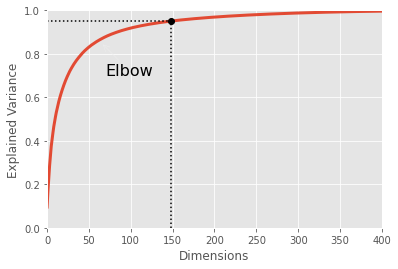

In [18]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [23]:
X_red_df = pd.DataFrame(X_reduced)
X_red_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147
0,1181.000072,-209.480410,-22.985194,438.129889,315.132347,883.650956,190.028127,-688.913975,225.660391,345.525384,-218.102095,15.336251,223.155555,-66.968008,-319.169318,-362.442211,525.764617,-54.660517,310.680037,-60.120779,-208.275524,56.078842,-90.211370,-307.531782,-43.407619,15.291980,225.172076,174.547682,-116.925180,-10.949315,200.794359,-62.190239,61.286485,-118.004545,-25.128810,-55.393263,-54.635828,84.035001,-9.096544,97.613819,-216.987959,-148.562270,-28.632707,27.450047,-190.965472,50.495439,-146.580598,133.973188,50.461239,-73.470526,-158.729341,-34.394403,-77.257143,97.346058,36.054816,70.212098,-14.590159,71.227665,39.192427,-45.529957,10.518620,-206.100267,-54.365080,-29.212001,29.542963,-74.305484,55.203439,97.743289,15.530501,-138.402386,17.408238,-61.834657,30.710202,-9.925997,39.090293,-26.983497,-88.693518,57.668916,68.098918,-15.484184,6.109369,58.559981,72.750518,-50.495503,26.144869,16.573187,-12.398848,-97.996825,12.170216,-39.948981,-1.807364,27.430506,33.678020,95.318765,-37.838509,90.429555,52.764691,-87.255117,38.765787,31.824437,3.421333,-64.698182,111.974449,-38.483475,-95.179859,51.363735,27.258293,-1.843050,-87.156126,-96.270898,-24.790764,7.918086,-57.833742,-1.208650,-46.820917,-88.064238,-24.887356,57.729126,10.990891,2.625778,-5.571620,-51.261462,-21.402454,-114.234118,14.154447,27.330306,86.097378,17.779240,9.988606,-37.782619,23.650029,-3.069974,46.916005,137.434911,-24.861390,-24.431607,-46.881763,-12.992115,-37.123434,-51.364288,-118.271811,-6.485510,26.420990,38.473712,-70.338561,1.999119,10.511526,36.992694
1,-740.981034,-847.869604,295.289583,128.141253,71.840697,-517.990820,-324.048273,-48.604178,439.463370,-105.154620,-435.696910,138.237171,95.029685,-188.336023,287.390074,-70.993241,0.995526,-77.486896,201.689758,-31.826868,-58.913296,38.521845,-128.120987,254.016066,-135.486035,-2.433474,121.377732,67.943291,63.395229,73.688982,59.548173,-31.457972,-9.316457,-4.787751,4.797198,-25.053976,17.125468,135.543651,-137.558682,42.969344,11.542427,-36.427797,71.808894,6.796554,-76.673777,-11.945288,-31.393493,58.826988,-9.270672,-51.745791,16.006369,63.196465,36.028116,29.698838,29.473715,57.164943,-60.886111,-15.339850,7.509670,15.938852,83.711191,-17.767360,-6.677615,-135.905814,-13.228581,-1.802444,-38.912302,-67.348297,2.797166,32.628060,32.566447,54.256932,19.394319,18.348570,19.329400,92.257757,-39.114339,0.613773,38.423010,-52.819597,48.946761,54.672154,35.953612,-11.265090,-17.423975,-17.319435,-46.152086,-1.933316,24.307636,53.549327,-9.224483,-13.696651,-2.652383,10.359715,-14.346333,54.717491,-15.540177,-11.065382,-1.236368,-69.875653,-1.526380,12.062857,-41.839548,7.980057,15.004203,-22.342154,-30.861650,-0.346625,12.402558,65.312323,18.893079,25.034725,6.494737,26.757502,-44.892195,-12.613276,17.307330,18.831257,3.650680,-62.404863,41.067629,-18.722491,21.288543,-15.887629,-3.920607,-2.255405,16.770678,-47.764780,-3.826016,13.918130,13.402100,3.270734,-17.387058,5.303932,21.089806,-34.918836,-41.938920,-33.583301,-8.571524,-35.561819,34.555636,-19.912834,1.272616,-30.064544,42.169726,-45.612351,51.188991,-38.751890
2,-306.992328,-666.497065,-206.805449,-70.693985,-11.980489,262.378256,-70.775655,41.310863,-84.245868,-349.508015,208.632860,-11.596085,128.905229,116.802694,454.765441,413.921902,90.364631,-56.832989,219.078323,-93.480775,112.695609,7.235357,-48.631351,-2.026611,-52.206443,-27.887043,-71.627191,42.834513,-279.007541,213.992731,-95.310455,74.389926,-209.967363,-339.393125,8.101967,-84.8

# **RF on PCA**

# **k-means clustering**